# Challenge : predict conversions 🏆

# Entrairement sur l'ensemble du dataset et export pour soumission au challenge
# meilleure approche retenue :
* modele SVM
* entrainement et prédictions séparés par pays puis consolidation
* Calibrage du meilleur seuil "proba" pour un meilleur f1-score 

## Import des modules

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn import svm

## Chargement des données

In [ ]:
data = pd.read_csv('./data/conversion_data_train.csv')
print('Set (train avec labels) :', data.shape)

data_wl = pd.read_csv('./data/conversion_data_test.csv')
print('Set (test sans label) :', data_wl.shape)

data_wl["converted"] = [-1 for i in range(0, data_wl.shape[0])]
data_wl["prob"] = [-1.0 for i in range(0, data_wl.shape[0])]

Set (train avec labels) : (284580, 6)
Set (test sans label) : (31620, 5)


## Suppression outlers

In [4]:
# suppression lignes avec age >= XX
data = data[data["age"] < 100]

## Traitement des entrainements et prédictions séparement pour chcun des pays (Modèle SVM)

### Fonction de recherche du seuil de probabilité optimun pour un meilleur f1_score

In [5]:
def best_prob_f1score(y_prob, y_real, seuil_step) :
    best_seuil = 0.5
    best_y_pred = np.array([0 if p[0] > best_seuil else 1 for p in y_prob])
    best_f1_score = f1_score(y_real, best_y_pred)

    
    for seuil in np.arange(0, 1, seuil_step) :
        y_pred = np.array([0 if p[0] > seuil else 1 for p in y_prob])
        seuil_f1_score = f1_score(y_real, y_pred)
        if seuil_f1_score > best_f1_score :
            best_seuil = seuil
            best_f1_score = seuil_f1_score
            best_y_pred = y_pred

    return (best_seuil, best_f1_score, best_y_pred)

### Traitement des entrainements et prédictions séparement pour chcun des pays
### Objectif : mieux tenir compte des disparités des désiquilibes du dataset par pays
### Normalement, Les modèles devraient tenir compte nativement du facteur "pays" mais celà semble être moins efficace

In [8]:
# Initialisation de listes pour consolider les resultats des prédictions faites séparément sur les différents pays 
Y_train_total = []
Y_train_pred_total = []
Y_train_prob_total = []

Y_wl_pred_total = []

for country in [["Germany"], ["US"], ["UK"], ["China"]] :

    num_features = ["age", "total_pages_visited"]
    cat_features = ["source", "new_user"]
    features_list = num_features + cat_features
    target_variable = 'converted'

    dataset = data[(data["country"].apply(lambda x : True if x in country else False))]
    X = dataset.loc[:, features_list]
    Y = dataset.loc[:, target_variable]

    dataset_wl = data_wl[(data_wl["country"].apply(lambda x : True if x in country else False))]
    X_wl = dataset_wl.loc[:, features_list]

    X_train, Y_train = X, Y


    numeric_transformer = Pipeline(steps=[("scaler", StandardScaler()),])
    categorical_transformer = Pipeline(steps=[("encoder", OneHotEncoder(drop="first")),])
    preprocessor = ColumnTransformer(transformers=[
            ("num", numeric_transformer, num_features),
            ("cat", categorical_transformer, cat_features),
        ]
    )

    X_train = preprocessor.fit_transform(X_train)
    X_wl = preprocessor.transform(X_wl)


    classifier = svm.SVC(kernel="poly", probability=True, C=10, random_state=42)

    classifier.fit(X_train, Y_train)

    # Predictions on training set
    Y_train_pred = classifier.predict(X_train)
    Y_train_prob = classifier.predict_proba(X_train)
     
    (best_seuil, best_f1_score_train, best_y_pred) = best_prob_f1score(Y_train_prob, Y_train, .001)

    print(f"{country}\t\tseuil : {best_seuil}\tf1_score_train : {best_f1_score_train}", X_train.shape)

    Y_train_total += list(Y_train)
    Y_train_pred_total += [0 if p[0] > best_seuil else 1 for p in Y_train_prob]
    # Y_train_prob_total += [p for p in Y_train_prob]
    Y_train_prob_total += list(Y_train_prob)

    # Predictions on without label set
    Y_wl_prob = classifier.predict_proba(X_wl)
    Y_wl_pred = np.array([0 if p[0] > best_seuil else 1 for p in Y_wl_prob])
    for ind, pred, prob in zip(dataset_wl.index, Y_wl_pred, Y_wl_prob) :
        data_wl.loc[ind, "converted"] = pred
        data_wl.loc[ind, "prob"] = prob[0]

print()
print("accuracy - train", accuracy_score(np.array(Y_train_total), np.array(Y_train_pred_total)))
print("f1 score - train", f1_score(np.array(Y_train_total), np.array(Y_train_pred_total)))

print()
print(confusion_matrix(np.array(Y_train_total), np.array(Y_train_pred_total)))

['Germany']		seuil : 0.934	f1_score_train : 0.8133514986376021 (11692, 5)
['US']		seuil : 0.907	f1_score_train : 0.7660905063840876 (160124, 5)
['UK']		seuil : 0.934	f1_score_train : 0.7827036470845162 (43640, 5)
['China']		seuil : 0.993	f1_score_train : 0.44171779141104295 (69122, 5)

accuracy - train 0.9857578590052639
f1 score - train 0.7713141116063872

[[273690   1710]
 [  2343   6835]]


## Export des predictions sur le dataset "sans label" pour soumission au challenge

In [ ]:
data2csv = {
    'converted': data_wl["converted"]
}
datap = {
    'converted': data_wl["converted"],
    'prob' : data_wl["prob"]
}

Y_predictions = pd.DataFrame(columns=['converted'], data=data2csv)
Y_predictions.to_csv('./data/conversion_data_test_predictions_SeddikV02B.csv', index=False)


# Soumission "SeddikV02B" est classée en rang 1er 🏆 du challenge :
options retenus :
* Entraitement et présitions séparement pars pays, puis consolidation 
* Optimisation du seuil de probabilité TReu/False pour un meilleur f1-score

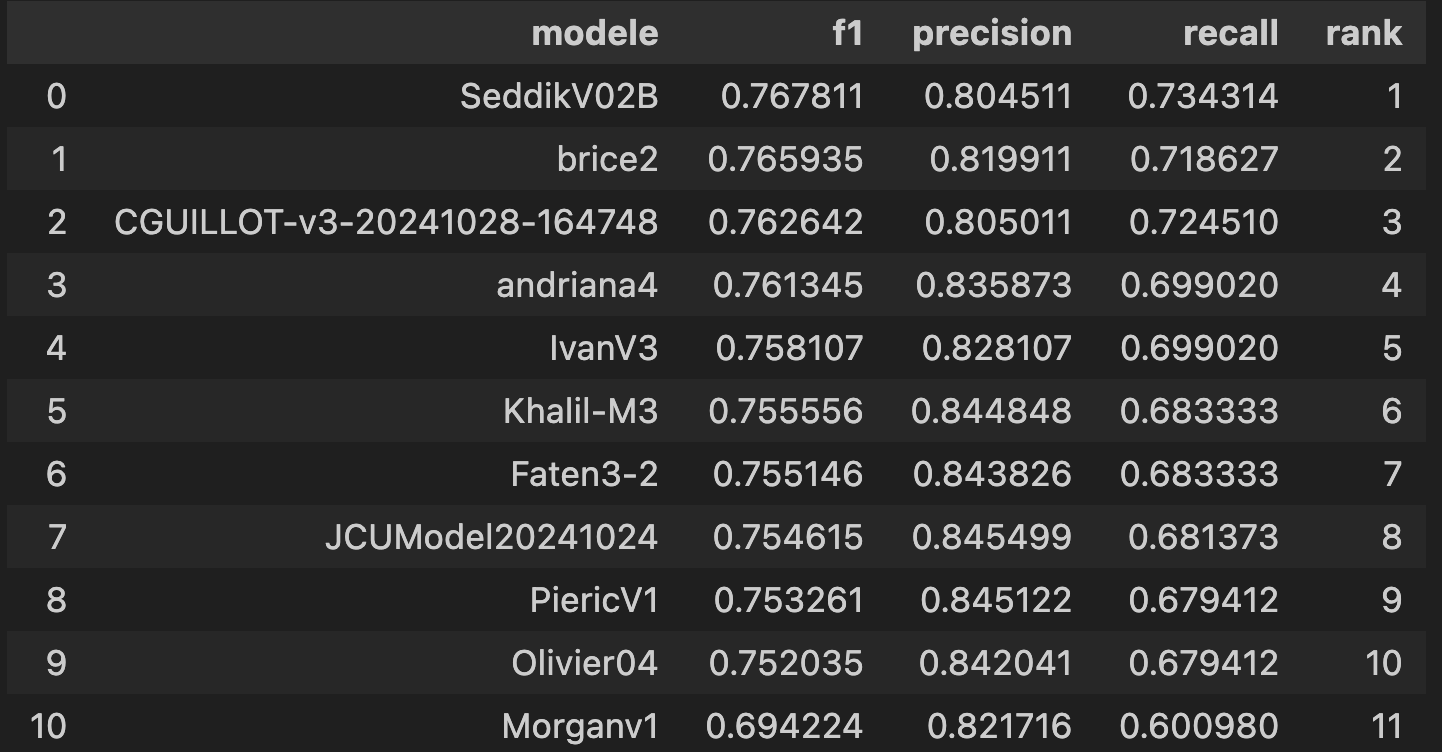